In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import keras
from keras import layers

import tensorflow as tf

from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image

In [ ]:
!wget https://huggingface.co/datasets/geekyrakshit/LoL-Dataset/resolve/main/lol_dataset.zip
!unzip -q lol_dataset.zip && rm lol_dataset.zip

--2024-03-19 14:26:32--  https://huggingface.co/datasets/geekyrakshit/LoL-Dataset/resolve/main/lol_dataset.zip
Resolving huggingface.co (huggingface.co)... 65.8.178.27, 65.8.178.12, 65.8.178.93, ...
Connecting to huggingface.co (huggingface.co)|65.8.178.27|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/d9/09/d909ef7668bb417b7065a311bd55a3084cc83a1f918e13cb41c5503328432db2/419fddc48958cd0f5599939ee0248852a37ceb8bb738c9b9525e95b25a89de9a?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27lol_dataset.zip%3B+filename%3D%22lol_dataset.zip%22%3B&response-content-type=application%2Fzip&Expires=1711117592&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxMTExNzU5Mn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy9kOS8wOS9kOTA5ZWY3NjY4YmI0MTdiNzA2NWEzMTFiZDU1YTMwODRjYzgzYTFmOTE4ZTEzY2I0MWM1NTAzMzI4NDMyZGIyLzQxOWZkZGM0ODk1OGNkMGY1NTk5OTM5ZWUwMjQ4ODUyYTM3

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 16
MAX_TRAIN_IMAGES = 400


def load_data(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = image / 255.0
    return image


def data_generator(low_light_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_low_light_images = sorted(glob("./lol_dataset/our485/low/*"))[:MAX_TRAIN_IMAGES]
val_low_light_images = sorted(glob("./lol_dataset/our485/low/*"))[MAX_TRAIN_IMAGES:]
test_low_light_images = sorted(glob("./lol_dataset/eval15/low/*"))


train_dataset = data_generator(train_low_light_images)
val_dataset = data_generator(val_low_light_images)

print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)


Train Dataset: <_BatchDataset element_spec=TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None)>
Validation Dataset: <_BatchDataset element_spec=TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None)>


In [ ]:
def build_dce_net():
    input_img = keras.Input(shape=[None, None, 3])
    conv1 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(input_img)
    conv2 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv1)
    conv3 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv2)
    conv4 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv3)
    int_con1 = layers.Concatenate(axis=-1)([conv4, conv3])
    conv5 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con1)
    int_con2 = layers.Concatenate(axis=-1)([conv5, conv2])
    conv6 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con2)
    int_con3 = layers.Concatenate(axis=-1)([conv6, conv1])
    x_r = layers.Conv2D(24, (3, 3), strides=(1, 1), activation="tanh", padding="same")(
        int_con3
    )
    return keras.Model(inputs=input_img, outputs=x_r)

In [ ]:
def color_constancy_loss(x):
    mean_rgb = tf.reduce_mean(x, axis=(1, 2), keepdims=True)
    mr, mg, mb = (
        mean_rgb[:, :, :, 0],
        mean_rgb[:, :, :, 1],
        mean_rgb[:, :, :, 2],
    )
    d_rg = tf.square(mr - mg)
    d_rb = tf.square(mr - mb)
    d_gb = tf.square(mb - mg)
    return tf.sqrt(tf.square(d_rg) + tf.square(d_rb) + tf.square(d_gb))

In [ ]:
def exposure_loss(x, mean_val=0.6):
    x = tf.reduce_mean(x, axis=3, keepdims=True)
    mean = tf.nn.avg_pool2d(x, ksize=16, strides=16, padding="VALID")
    return tf.reduce_mean(tf.square(mean - mean_val))

In [ ]:
def illumination_smoothness_loss(x):
    batch_size = tf.shape(x)[0]
    h_x = tf.shape(x)[1]
    w_x = tf.shape(x)[2]
    count_h = (tf.shape(x)[2] - 1) * tf.shape(x)[3]
    count_w = tf.shape(x)[2] * (tf.shape(x)[3] - 1)
    h_tv = tf.reduce_sum(tf.square((x[:, 1:, :, :] - x[:, : h_x - 1, :, :])))
    w_tv = tf.reduce_sum(tf.square((x[:, :, 1:, :] - x[:, :, : w_x - 1, :])))
    batch_size = tf.cast(batch_size, dtype=tf.float32)
    count_h = tf.cast(count_h, dtype=tf.float32)
    count_w = tf.cast(count_w, dtype=tf.float32)
    return 2 * (h_tv / count_h + w_tv / count_w) / batch_size

In [ ]:
class SpatialConsistencyLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(reduction="none")

        self.left_kernel = tf.constant(
            [[[[0, 0, 0]], [[-1, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.right_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, -1]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.up_kernel = tf.constant(
            [[[[0, -1, 0]], [[0, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.down_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, 0]], [[0, -1, 0]]]], dtype=tf.float32
        )

    def call(self, y_true, y_pred):
        original_mean = tf.reduce_mean(y_true, 3, keepdims=True)
        enhanced_mean = tf.reduce_mean(y_pred, 3, keepdims=True)
        original_pool = tf.nn.avg_pool2d(
            original_mean, ksize=4, strides=4, padding="VALID"
        )
        enhanced_pool = tf.nn.avg_pool2d(
            enhanced_mean, ksize=4, strides=4, padding="VALID"
        )

        d_original_left = tf.nn.conv2d(
            original_pool,
            self.left_kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )
        d_original_right = tf.nn.conv2d(
            original_pool,
            self.right_kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )
        d_original_up = tf.nn.conv2d(
            original_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_down = tf.nn.conv2d(
            original_pool,
            self.down_kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )

        d_enhanced_left = tf.nn.conv2d(
            enhanced_pool,
            self.left_kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )
        d_enhanced_right = tf.nn.conv2d(
            enhanced_pool,
            self.right_kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )
        d_enhanced_up = tf.nn.conv2d(
            enhanced_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_down = tf.nn.conv2d(
            enhanced_pool,
            self.down_kernel,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )

        d_left = tf.square(d_original_left - d_enhanced_left)
        d_right = tf.square(d_original_right - d_enhanced_right)
        d_up = tf.square(d_original_up - d_enhanced_up)
        d_down = tf.square(d_original_down - d_enhanced_down)
        return d_left + d_right + d_up + d_down

In [ ]:
class ZeroDCE(keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.dce_model = build_dce_net()

    def compile(self, learning_rate, **kwargs):
        super().compile(**kwargs)
        self.optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        self.spatial_constancy_loss = SpatialConsistencyLoss(reduction="none")
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.illumination_smoothness_loss_tracker = keras.metrics.Mean(
            name="illumination_smoothness_loss"
        )
        self.spatial_constancy_loss_tracker = keras.metrics.Mean(
            name="spatial_constancy_loss"
        )
        self.color_constancy_loss_tracker = keras.metrics.Mean(
            name="color_constancy_loss"
        )
        self.exposure_loss_tracker = keras.metrics.Mean(name="exposure_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.illumination_smoothness_loss_tracker,
            self.spatial_constancy_loss_tracker,
            self.color_constancy_loss_tracker,
            self.exposure_loss_tracker,
        ]

    def get_enhanced_image(self, data, output):
        r1 = output[:, :, :, :3]
        r2 = output[:, :, :, 3:6]
        r3 = output[:, :, :, 6:9]
        r4 = output[:, :, :, 9:12]
        r5 = output[:, :, :, 12:15]
        r6 = output[:, :, :, 15:18]
        r7 = output[:, :, :, 18:21]
        r8 = output[:, :, :, 21:24]
        x = data + r1 * (tf.square(data) - data)
        x = x + r2 * (tf.square(x) - x)
        x = x + r3 * (tf.square(x) - x)
        enhanced_image = x + r4 * (tf.square(x) - x)
        x = enhanced_image + r5 * (tf.square(enhanced_image) - enhanced_image)
        x = x + r6 * (tf.square(x) - x)
        x = x + r7 * (tf.square(x) - x)
        enhanced_image = x + r8 * (tf.square(x) - x)
        return enhanced_image

    def call(self, data):
        dce_net_output = self.dce_model(data)
        return self.get_enhanced_image(data, dce_net_output)

    def compute_losses(self, data, output):
        enhanced_image = self.get_enhanced_image(data, output)
        loss_illumination = 200 * illumination_smoothness_loss(output)
        loss_spatial_constancy = tf.reduce_mean(
            self.spatial_constancy_loss(enhanced_image, data)
        )
        loss_color_constancy = 5 * tf.reduce_mean(color_constancy_loss(enhanced_image))
        loss_exposure = 10 * tf.reduce_mean(exposure_loss(enhanced_image))
        total_loss = (
            loss_illumination
            + loss_spatial_constancy
            + loss_color_constancy
            + loss_exposure
        )

        return {
            "total_loss": total_loss,
            "illumination_smoothness_loss": loss_illumination,
            "spatial_constancy_loss": loss_spatial_constancy,
            "color_constancy_loss": loss_color_constancy,
            "exposure_loss": loss_exposure,
        }

    def train_step(self, data):
        with tf.GradientTape() as tape:
            output = self.dce_model(data)
            losses = self.compute_losses(data, output)

        gradients = tape.gradient(
            losses["total_loss"], self.dce_model.trainable_weights
        )
        self.optimizer.apply_gradients(zip(gradients, self.dce_model.trainable_weights))

        self.total_loss_tracker.update_state(losses["total_loss"])
        self.illumination_smoothness_loss_tracker.update_state(
            losses["illumination_smoothness_loss"]
        )
        self.spatial_constancy_loss_tracker.update_state(
            losses["spatial_constancy_loss"]
        )
        self.color_constancy_loss_tracker.update_state(losses["color_constancy_loss"])
        self.exposure_loss_tracker.update_state(losses["exposure_loss"])

        return {metric.name: metric.result() for metric in self.metrics}

    def test_step(self, data):
        output = self.dce_model(data)
        losses = self.compute_losses(data, output)

        self.total_loss_tracker.update_state(losses["total_loss"])
        self.illumination_smoothness_loss_tracker.update_state(
            losses["illumination_smoothness_loss"]
        )
        self.spatial_constancy_loss_tracker.update_state(
            losses["spatial_constancy_loss"]
        )
        self.color_constancy_loss_tracker.update_state(losses["color_constancy_loss"])
        self.exposure_loss_tracker.update_state(losses["exposure_loss"])

        return {metric.name: metric.result() for metric in self.metrics}

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        """While saving the weights, we simply save the weights of the DCE-Net"""
        self.dce_model.save_weights(
            filepath,
            overwrite=overwrite,
            save_format=save_format,
            options=options,
        )

    def load_weights(self, filepath, by_name=False, skip_mismatch=False, options=None):
        """While loading the weights, we simply load the weights of the DCE-Net"""
        self.dce_model.load_weights(
            filepath=filepath,
            by_name=by_name,
            skip_mismatch=skip_mismatch,
            options=options,
        )

Epoch 1/100
25/25 [==============================] - 19s 326ms/step - total_loss: 5.6459 - illumination_smoothness_loss: 2.7067 - spatial_constancy_loss: 2.2283e-05 - color_constancy_loss: 0.0031 - exposure_loss: 2.9360 - val_total_loss: 6.2477 - val_illumination_smoothness_loss: 3.3029 - val_spatial_constancy_loss: 1.8771e-05 - val_color_constancy_loss: 0.0022 - val_exposure_loss: 2.9426
Epoch 2/100
25/25 [==============================] - 7s 266ms/step - total_loss: 4.5694 - illumination_smoothness_loss: 1.6403 - spatial_constancy_loss: 3.1413e-05 - color_constancy_loss: 0.0030 - exposure_loss: 2.9261 - val_total_loss: 5.1202 - val_illumination_smoothness_loss: 2.1868 - val_spatial_constancy_loss: 3.4222e-05 - val_color_constancy_loss: 0.0023 - val_exposure_loss: 2.9311
Epoch 3/100
25/25 [==============================] - 7s 262ms/step - total_loss: 4.0379 - illumination_smoothness_loss: 1.1200 - spatial_constancy_loss: 5.1372e-05 - color_constancy_loss: 0.0029 - exposure_loss: 2.914

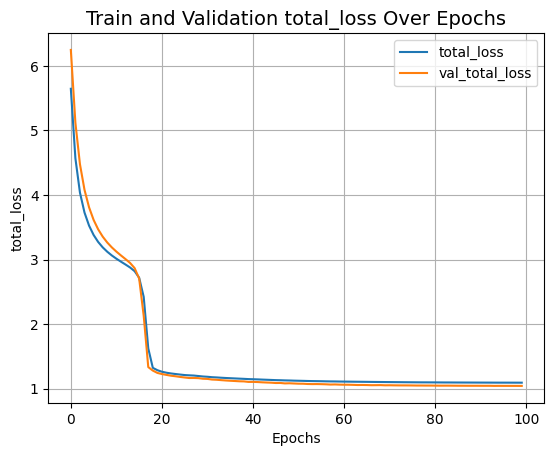

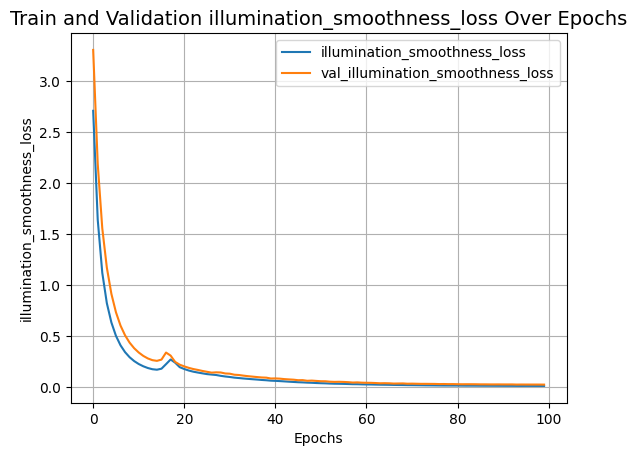

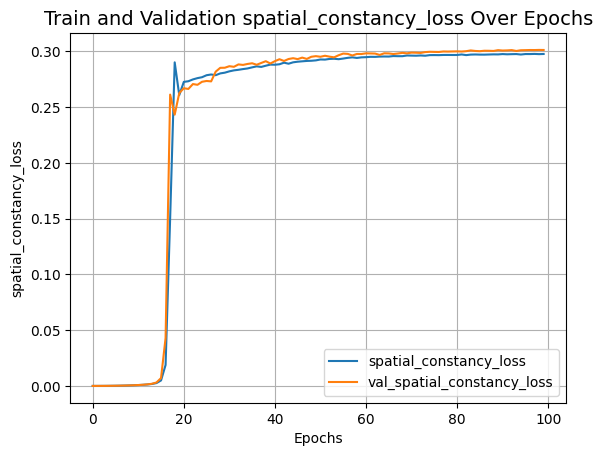

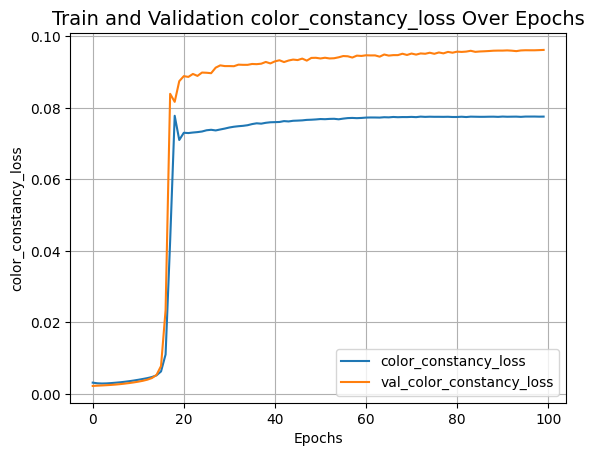

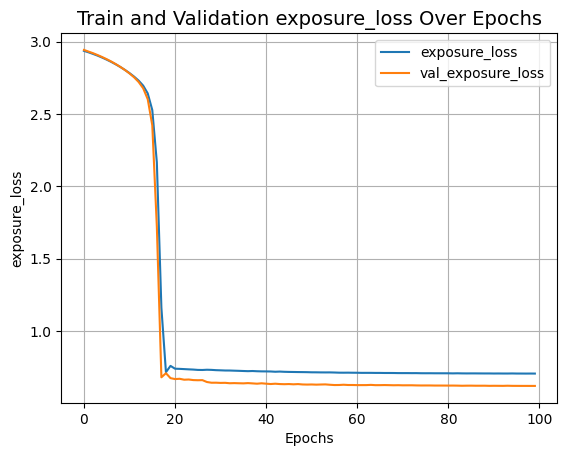

In [ ]:
zero_dce_model = ZeroDCE()
zero_dce_model.compile(learning_rate=1e-4)
history = zero_dce_model.fit(train_dataset, validation_data=val_dataset, epochs=100)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("total_loss")
plot_result("illumination_smoothness_loss")
plot_result("spatial_constancy_loss")
plot_result("color_constancy_loss")
plot_result("exposure_loss")

In [ ]:
zero_dce_model.save_weights('my_model_weights.h5')
print("successful")

successful


In [ ]:
def load_and_process_image(file_path, model, img_size=(256, 256)):
    if not os.path.isfile(file_path):
        print(f"Error: File '{file_path}' not found.")
        return

    img = load_img(file_path, target_size=img_size)


    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)


    enhanced_img_array = model.predict(img_array)[0]
    enhanced_img_array = np.clip(enhanced_img_array, 0, 1)

    original_img = (img_array[0] * 255).astype(np.uint8)
    enhanced_img = (enhanced_img_array * 255).astype(np.uint8)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].imshow(original_img)
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    axs[1].imshow(enhanced_img)
    axs[1].set_title('Enhanced Image')
    axs[1].axis('off')
    plt.show()

file_path = '/content/Screenshot 2024-02-10 211121.png'
load_and_process_image(file_path, zero_dce_model)


Error: File '/content/Screenshot 2024-02-10 211121.png' not found.


1/1 [==============================] - 1s 654ms/step


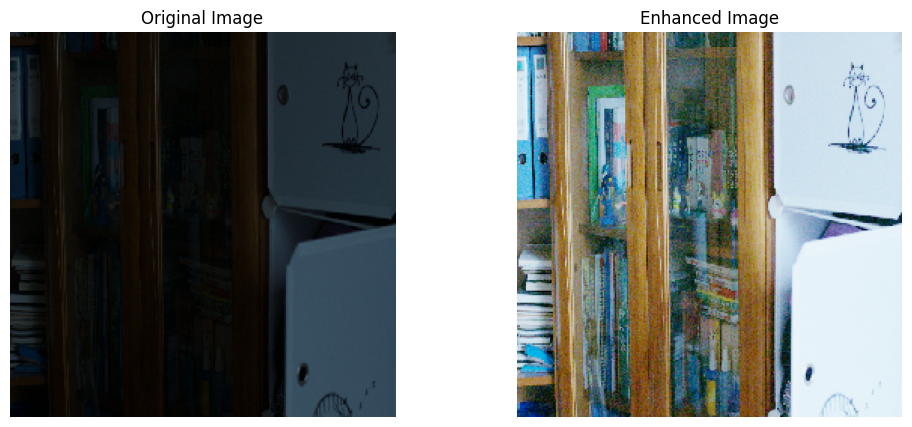

In [ ]:
file_path = '/content/lol_dataset/eval15/low/1.png'
load_and_process_image(file_path, zero_dce_model)

1/1 [==============================] - 0s 24ms/step


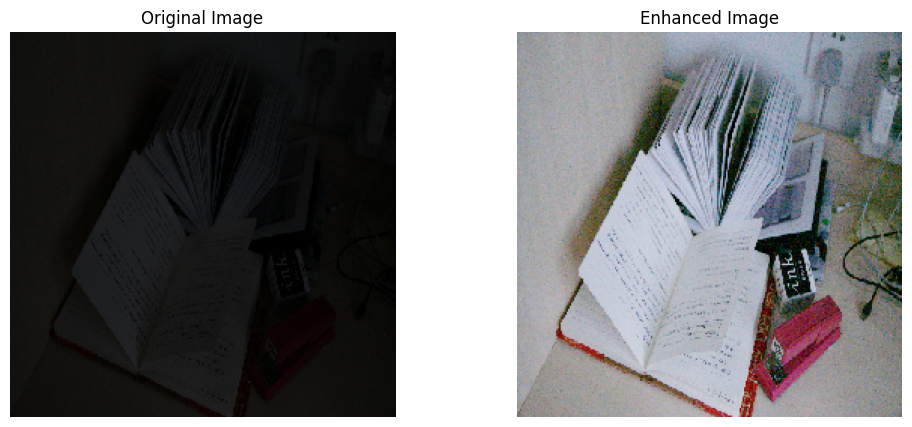

In [ ]:
file_path = '/content/lol_dataset/eval15/low/547.png'
load_and_process_image(file_path, zero_dce_model)

In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

def load_image(file_path):
    img = Image.open(file_path)
    return img

img = cv.imread('/content/Screenshot 2024-03-18 000406.png')
dst = cv.fastNlMeansDenoisingColored(img,None,10,10,7,21)
plt.subplot(121),plt.imshow(img)
plt.subplot(122),plt.imshow(dst)
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Replace 'your_model.h5' with the path to your actual model file
model_path = '/content/super_res.h5'
model = load_model(model_path)

# Now your model is loaded and ready to make predictions.
# For example, to predict on new data:

# Assuming `x_test` is your input data
# x_test = ...

# Make predictions
# predictions = model.predict(x_test)

# Print predictions or process them further
# print(predictions)


import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array

def load_and_process_image(file_path, model, img_size=(256, 256)):
    if not os.path.isfile(file_path):
        print(f"Error: File '{file_path}' not found.")
        return

    # Load the image
    img = load_img(file_path, target_size=img_size)

    # Convert image to array and normalize
    img_array = img_to_array(img) / 255.0

    # Expand dimensions to match model input shape
    img_array = np.expand_dims(img_array, axis=0)

    # Predict enhanced image using the model
    enhanced_img_array = model.predict(img_array)[0]

    # Clip pixel values to [0, 1]
    enhanced_img_array = np.clip(enhanced_img_array, 0, 1)

    # Convert back to uint8 and scale to [0, 255]
    original_img = (img_array[0] * 255).astype(np.uint8)
    enhanced_img = (enhanced_img_array * 255).astype(np.uint8)

    # Plot original and enhanced images
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].imshow(original_img)
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    axs[1].imshow(enhanced_img)
    axs[1].set_title('Enhanced Image')
    axs[1].axis('off')
    plt.show()

# Example usage
file_path = '/content/Screenshot 2024-03-18 011542.png'
load_and_process_image(file_path, model)



In [ ]:
!ls /content/

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def build_dce_net():
    input_img = keras.Input(shape=[None, None, 3])
    conv1 = layers.Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same")(input_img)
    conv2 = layers.Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same")(conv1)
    conv3 = layers.Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same")(conv2)
    conv4 = layers.Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same")(conv3)
    int_con1 = layers.Concatenate(axis=-1)([conv4, conv3])
    conv5 = layers.Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same")(int_con1)
    int_con2 = layers.Concatenate(axis=-1)([conv5, conv2])
    conv6 = layers.Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same")(int_con2)
    int_con3 = layers.Concatenate(axis=-1)([conv6, conv1])
    x_r = layers.Conv2D(24, (3, 3), strides=(1, 1), activation="tanh", padding="same")(int_con3)
    return keras.Model(inputs=input_img, outputs=x_r)


# Create the model
model = build_dce_net()

In [ ]:
# Load the pre-trained weights
weights_path = '/content/my_model_weights.h5'  # Update this path to your .h5 file
model.load_weights(weights_path)


In [ ]:
model.summary()

In [ ]:
def load_and_process_image(file_path, model, img_size=(256, 256)):
    if not os.path.isfile(file_path):
        print(f"Error: File '{file_path}' not found.")
        return

    img = load_img(file_path, target_size=img_size)


    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)


    enhanced_img_array = model.predict(img_array)[0]
    enhanced_img_array = np.clip(enhanced_img_array, 0, 1)

    original_img = (img_array[0] * 255).astype(np.uint8)
    enhanced_img = (enhanced_img_array * 255).astype(np.uint8)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].imshow(original_img)
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    axs[1].imshow(enhanced_img)
    axs[1].set_title('Enhanced Image')
    axs[1].axis('off')
    plt.show()

file_path = '/content/lol_dataset/eval15/low/111.png'
load_and_process_image(file_path,model)

In [ ]:
model = ZeroDCE()
model.compile(learning_rate=1e-4)
model.load_weights('/content/my_model_weights.h5')

In [ ]:
def load_and_process_image(file_path, model, img_size=(256, 256)):
    if not os.path.isfile(file_path):
        print(f"Error: File '{file_path}' not found.")
        return

    img = load_img(file_path, target_size=img_size)


    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)


    enhanced_img_array = model.predict(img_array)[0]
    enhanced_img_array = np.clip(enhanced_img_array, 0, 1)

    original_img = (img_array[0] * 255).astype(np.uint8)
    enhanced_img = (enhanced_img_array * 255).astype(np.uint8)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].imshow(original_img)
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    axs[1].imshow(enhanced_img)
    axs[1].set_title('Enhanced Image')
    axs[1].axis('off')
    plt.show()

file_path = '/content/lol_dataset/eval15/low/111.png'
load_and_process_image(file_path,model)